In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.animation as animation # animation

import os
import netCDF4 as nc
import matplotlib as mpl
import shapefile
import pyproj

import fiona
from shapely.geometry import shape
import rasterio
import rasterio.transform
import rasterio.mask
from fiona import Feature, Geometry
from shapely.geometry import mapping, shape
import os

from scipy.ndimage import binary_dilation

from rasterio.warp import reproject, Resampling
from rasterio.crs import CRS
from osgeo import gdal

In [2]:
common_years = np.arange(2005,2017,1)

selecao_path = '/Users/francesco/Desktop/Thesis/Data/dataset_filtered/selecao.txt' #CHANGE IN CLUSTER
ids_selecao = np.loadtxt(selecao_path, dtype=int)

In [3]:
#get information from the shp file, without creating the output tif files

shapefile_path = '/Users/francesco/Desktop//Thesis/Data/ice_shelf.shp'

ids = []
Names = []
boundaries = []

shapefile=fiona.open(shapefile_path)

for feature in shapefile:

    id = feature['properties']['id']
    name=feature['properties']['name']
    geometry=feature['geometry']
    if geometry is None:
        continue

    bounds=shape(geometry).bounds

    #I expand the boundaries of 5000 m (10 pixels)
    xmin=bounds[0]-5000;ymin=bounds[1]-5000;xmax=bounds[2]+5000;ymax=bounds[3]+5000

    #Condition for Twaithes
    if id == 56:
        xmin=bounds[0]-57000;ymin=bounds[1]-50000;xmax=bounds[2]+50000;ymax=bounds[3]+10000

    #Taking the info
    ids.append(id)
    Names.append(name)
    boundaries.append([xmin,xmax,ymin,ymax])

#create a dataset with the information retrived from the previous bloc
df = pd.DataFrame({ 'Names':Names, 'boundaries': boundaries}, index = ids)

# I want to sort this dataset according to the index
df = df.sort_index()
pd.set_option('display.max_rows', None)

#Select just selecao
df = df[np.isin(df.index, ids_selecao)]

In [4]:
#in this script i want to create a list of all the files i want to open

root = '/Users/francesco/Desktop/Thesis/Data/monthly/seaice_conc_monthly_sh_'

#################### first block ####################
start_date = "1978-11"
end_date = "1987-07"

date_range = pd.date_range(start=start_date, end=end_date, freq="MS")
date_list_1 = [date.strftime("%Y%m") for date in date_range]

end_1 = '_n07_v04r00.tif'
#################### second block ####################
start_date = "1987-08"
end_date = "1991-12"

date_range = pd.date_range(start=start_date, end=end_date, freq="MS")
date_list_2 = [date.strftime("%Y%m") for date in date_range]
end_2 = '_f08_v04r00.tif'
#################### third block ####################
start_date = "1992-01"
end_date = "1995-09"

date_range = pd.date_range(start=start_date, end=end_date, freq="MS")
date_list_3 = [date.strftime("%Y%m") for date in date_range]
end_3 = '_f11_v04r00.tif'
#################### fourth block ####################
start_date = "1995-10"
end_date = "2007-12"

date_range = pd.date_range(start=start_date, end=end_date, freq="MS")
date_list_4 = [date.strftime("%Y%m") for date in date_range]
end_4 = '_f13_v04r00.tif'
#################### fifth block ####################
start_date = "2008-01"
end_date = "2022-12"

date_range = pd.date_range(start=start_date, end=end_date, freq="MS")
date_list_5 = [date.strftime("%Y%m") for date in date_range]
end_5 = '_f17_v04r00.tif'
#####################################################

primo = []
for i in date_list_1:
    tmp = root + str(i) + end_1
    primo.append(tmp)

secondo = []
for i in date_list_2:
    tmp = root + str(i) + end_2
    secondo.append(tmp)

terzo = []
for i in date_list_3:
    tmp = root + str(i) + end_3
    terzo.append(tmp)

quarto = []
for i in date_list_4:
    tmp = root + str(i) + end_4
    quarto.append(tmp)

quinto = []
for i in date_list_5:
    tmp = root + str(i) + end_5
    quinto.append(tmp)

#now i want to merge the lists
#list_of_files = primo + secondo + terzo + quarto + quinto
list_of_files = terzo + quarto + quinto
list_of_files = list_of_files[156:300] #this way i am selecting from 2005 till 2016 (included)

In [5]:
#load the datasets (is stored in thickness directory, i should change it)
thickness_dir = '/Users/francesco/Desktop/Thesis/Thickness'

ice_mask = np.load(thickness_dir+'/ice_mask.npy', allow_pickle=True) #CHANGE IN CLUSTER
sea_mask = np.load(thickness_dir+'/sea_mask.npy', allow_pickle=True)
land_mask = np.load(thickness_dir+'/land_mask.npy', allow_pickle=True)
grounded_ice_mask = np.load(thickness_dir+'/grounded_ice_mask.npy', allow_pickle=True)

#crete the dataframes
ice_mask = pd.DataFrame(ice_mask, index = df.index, columns = common_years)
sea_mask = pd.DataFrame(sea_mask, index = df.index, columns = common_years)
land_mask = pd.DataFrame(land_mask, index = df.index, columns = common_years)
grounded_ice_mask = pd.DataFrame(grounded_ice_mask, index = df.index, columns = common_years)

In [6]:
not_sea_mask = pd.DataFrame(index = df.index, columns = common_years)

for id in df.index:
    for year in common_years:
        not_sea_mask.loc[id,year] = (land_mask.loc[id,year] | grounded_ice_mask.loc[id,year] | ice_mask.loc[id,year])

In [7]:
#Create a mask for the borders

sea_mask = np.load(thickness_dir+'/sea_mask.npy', allow_pickle=True)
sea_mask = pd.DataFrame(sea_mask, index = df.index, columns = common_years)

ice_mask = np.load(thickness_dir+'/ice_mask.npy', allow_pickle=True) #CHANGE IN CLUSTER
ice_mask = pd.DataFrame(ice_mask, index = df.index, columns = common_years)
ice_mask_expanded = ice_mask.copy()

land_mask = np.load(thickness_dir+'/land_mask.npy', allow_pickle=True)
land_mask = pd.DataFrame(land_mask, index = df.index, columns = common_years)
land_mask_expanded = land_mask.copy()

grounded_ice_mask = np.load(thickness_dir+'/grounded_ice_mask.npy', allow_pickle=True)
grounded_ice_mask = pd.DataFrame(grounded_ice_mask, index = df.index, columns = common_years)
grounded_ice_mask_expanded = grounded_ice_mask.copy()

sea_borders = pd.DataFrame(index = df.index, columns = common_years)

for id in df.index:

    for year in common_years:

        land_mask_expanded.loc[id, year] = binary_dilation(land_mask_expanded.loc[id, year], iterations=1)
        ice_mask_expanded.loc[id, year] = binary_dilation(ice_mask_expanded.loc[id, year], iterations=1)
        grounded_ice_mask_expanded.loc[id, year] = binary_dilation(grounded_ice_mask_expanded.loc[id, year], iterations=1)

        sea_borders.loc[id,year] = sea_mask.loc[id,year] & (land_mask_expanded.loc[id,year] | grounded_ice_mask_expanded.loc[id,year] | ice_mask_expanded.loc[id,year])
    

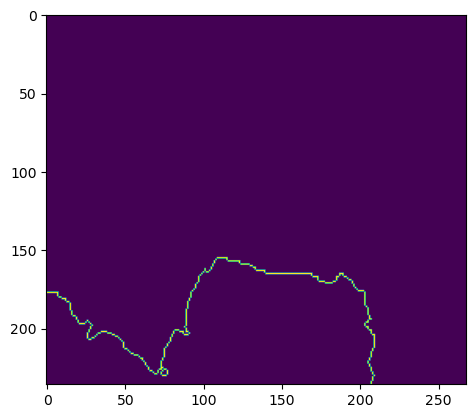

In [8]:
plt.imshow(sea_borders.loc[55,2005])

In [9]:
#Check where we need to interpolate (30 seconds)

sea_ice_concentration_tif = pd.DataFrame(index = df.index, columns = common_years)
parts_to_interpolate = pd.DataFrame(index = df.index, columns = common_years)

#reload the masks
sea_mask = np.load(thickness_dir+'/sea_mask.npy', allow_pickle=True)
sea_mask = pd.DataFrame(sea_mask, index = df.index, columns = common_years)

for id in df.index:
    print('Region ', id)
    xmin, xmax, ymin, ymax = df['boundaries'].loc[id]

    for file, year in zip(list_of_files, common_years):
        with rasterio.open(file, crs='EPSG:3031') as src:

            window = rasterio.windows.from_bounds(xmin, ymin, xmax, ymax, transform=src.transform)
            image = src.read(1, window=window)  # this is sea ice concentration

            # Here I extract the sea ice concentration where there is the ice mask
            sea_ice_tmp = np.where(sea_mask.loc[id, year] == True, image, np.nan)

            #Create a mask where data is equal to 251, 252, 253, 254, or 255, the regions where we will interpolate
            parts_to_interpolate.loc[id,year] = (sea_ice_tmp >= 251) & (sea_ice_tmp <= 255)

            sea_ice_tmp = np.where(parts_to_interpolate.loc[id,year] == True, np.nan, sea_ice_tmp)

            sea_ice_concentration_tif.loc[id, year] = sea_ice_tmp


Region  2
Region  3
Region  4
Region  6
Region  7
Region  8
Region  10
Region  12
Region  15
Region  16
Region  17
Region  18
Region  19
Region  24
Region  26
Region  29
Region  30
Region  31
Region  32
Region  33
Region  34
Region  35
Region  36
Region  37
Region  38
Region  39
Region  40
Region  41
Region  43
Region  44
Region  45
Region  46
Region  47
Region  48
Region  50
Region  52
Region  53
Region  54
Region  55
Region  56
Region  57
Region  58
Region  60
Region  61
Region  62
Region  63
Region  64
Region  65
Region  66
Region  67
Region  68
Region  69
Region  70
Region  71
Region  72
Region  73
Region  75
Region  76
Region  77
Region  78
Region  80
Region  81
Region  82
Region  83
Region  84
Region  85
Region  86
Region  87
Region  88
Region  89
Region  90
Region  91
Region  92
Region  93
Region  95
Region  96
Region  97
Region  98
Region  99
Region  100
Region  101
Region  102
Region  104
Region  105
Region  107
Region  108
Region  109
Region  110
Region  111
Region  112
Regio

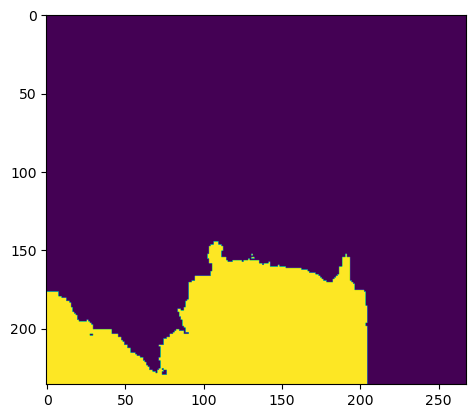

In [10]:
#plt.imshow(parts_to_interpolate.loc[55,2010])
plt.imshow(np.isnan(sea_ice_concentration_tif.loc[55,2010]))

#plt.imshow(np.where(np.isnan(sea_ice_concentration_tif.loc[55, 2010]), True, False))

sea_ice_not_nan = (parts_to_interpolate.loc[55, 2010] ==False ) & (sea_mask.loc[55, 2010] == True)

plt.imshow(sea_ice_not_nan)

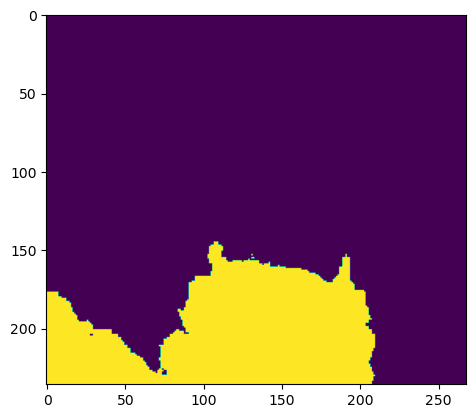

In [11]:
plt.imshow(sea_mask.loc[55, 2010])

In [12]:
sea_ice_not_nan = pd.DataFrame(index = df.index, columns = common_years)

for id in df.index:

    for year in common_years:

        sea_ice_not_nan.loc[id,year] = (parts_to_interpolate.loc[id, year] ==False ) & (sea_mask.loc[id, year] == True)


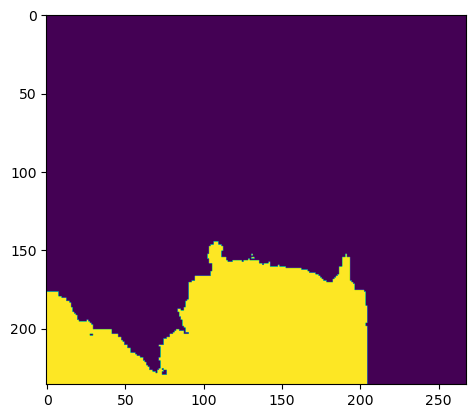

In [13]:
plt.imshow(sea_ice_not_nan.loc[55, 2010])

The size of sea_ice_not_nan is  (386, 395)  and the size of parts_to_interpolate is  (386, 395)


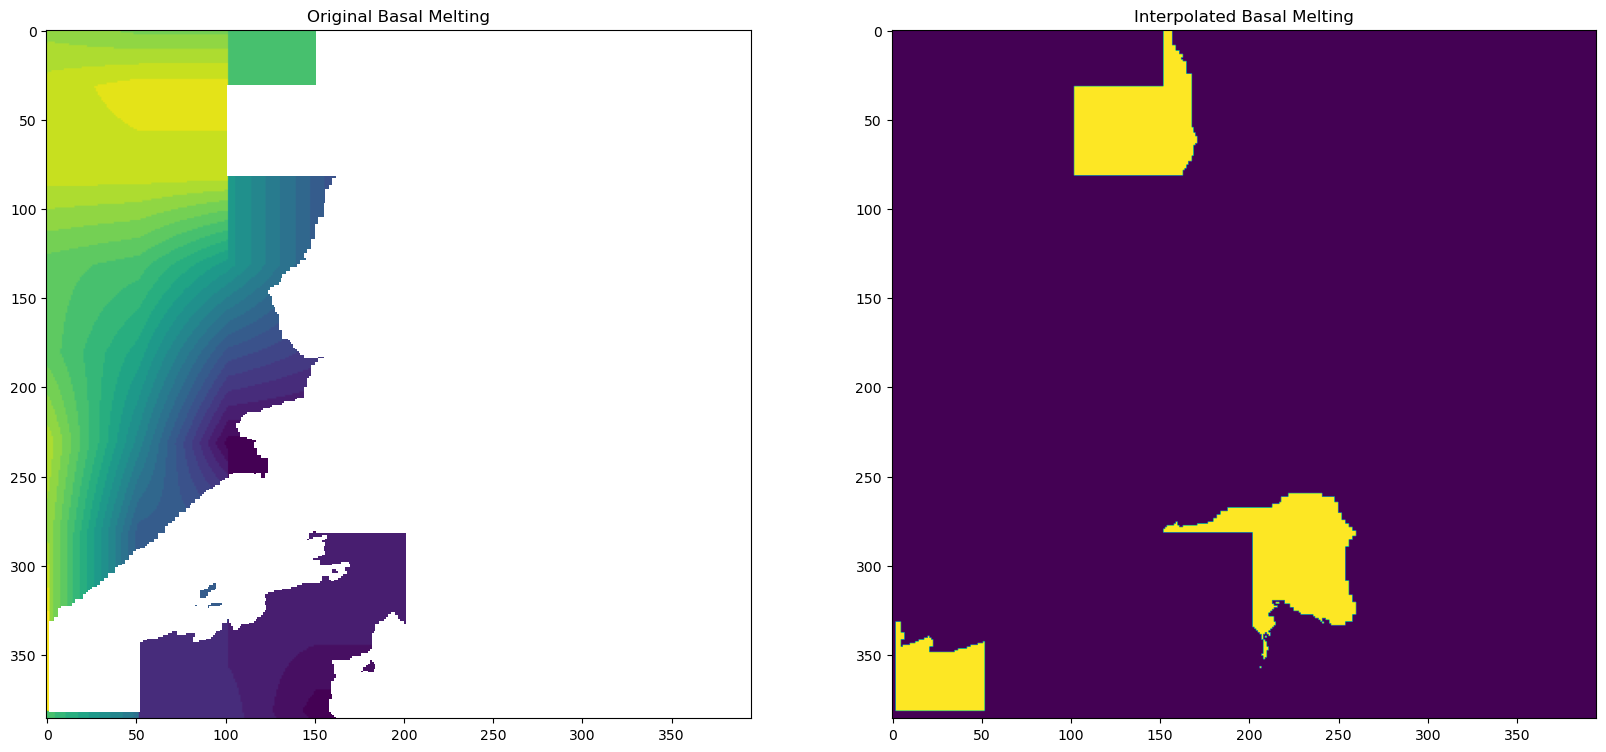

In [14]:


id = 56
year = 2010

#create 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

#plot the first subplot
ax1.imshow(sea_ice_concentration_tif.loc[id,year])
ax1.set_title('Original Basal Melting')

#plot the second subplot
ax2.imshow(parts_to_interpolate.loc[id,year])
ax2.set_title('Interpolated Basal Melting')

print('The size of sea_ice_not_nan is ', np.shape(sea_ice_not_nan.loc[id,year]), ' and the size of parts_to_interpolate is ', np.shape(parts_to_interpolate.loc[id,year]))


In [15]:
plt.imshow()

TypeError: imshow() missing 1 required positional argument: 'X'

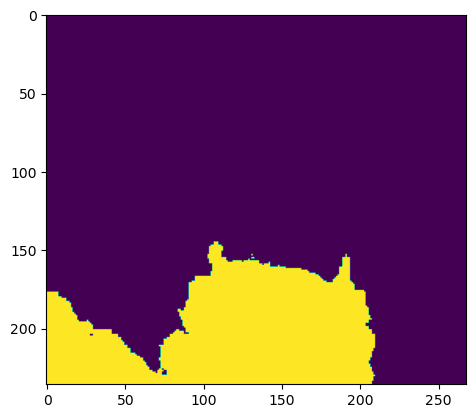

In [16]:
id = 55
year = 2010

mask = parts_to_interpolate.loc[id, year]
sea_ice = sea_ice_concentration_tif.loc[id, year]
complete_mask = mask | ~np.isnan(sea_ice)

plt.imshow(complete_mask)

In [17]:
#Make the interpolation

import numpy as np
from scipy.interpolate import RegularGridInterpolator
from scipy.interpolate import griddata
from skimage.restoration import inpaint
 
interpolated_values = pd.DataFrame(index = df.index, columns = common_years)

for id in df.index:

    print('Region ', id)
    
    for year in common_years:

        #sea_ice_nan = np.where(np.isnan(sea_ice_concentration_tif.loc[region_id, year]))
        #mask = parts_to_interpolate.loc[id, year]
        sea_ice = sea_ice_concentration_tif.loc[id, year]
        mask = np.isnan(sea_ice)
        #complete_mask = mask | ~np.isnan(sea_ice)

        #print('The shape of the mask is ', mask.shape, ' and the shape of the sea ice is ', sea_ice.shape)
        sea_ice = inpaint.inpaint_biharmonic(sea_ice, mask)

        sea_ice = np.where(sea_mask.loc[id,year] == True, sea_ice, 0)

        #sea_ice_not_nan_mask = (parts_to_interpolate.loc[id, year] ==False ) & (sea_mask.loc[id, year] == True) #Where I have values

        #sea_ice_not_nan = np.where(~np.isnan(sea_ice_concentration_tif.loc[region_id, year]))

        # Check if sea_ice_not_nan is not empty before calling griddata
#        if sea_ice_not_nan[0].size > 0:
#            sea_ice_values = sea_ice_concentration_tif.loc[region_id, year][sea_ice_not_nan_mask]
#            interpolated_values.loc[region_id, year] = griddata(
#                sea_ice_not_nan, sea_ice_values, sea_ice_nan, method='linear'
#            )
#        else:
            # Set a default or NaN value when there are no valid points
            #interpolated_values.loc[region_id, year] = np.nan  # or set to a default value


        #interpolated_values.loc[region_id, year] = griddata(sea_ice_not_nan, sea_ice_not_nan_value, sea_ice_nan, method='linear')



Region  2
Region  3
Region  4
Region  6
Region  7
Region  8
Region  10
Region  12
Region  15
Region  16
Region  17
Region  18
Region  19
Region  24
Region  26
Region  29
Region  30
Region  31
Region  32
Region  33
Region  34
Region  35
Region  36
Region  37
Region  38
Region  39
Region  40
Region  41
Region  43
Region  44
Region  45
Region  46
Region  47


ValueError: zero-size array to reduction operation minimum which has no identity

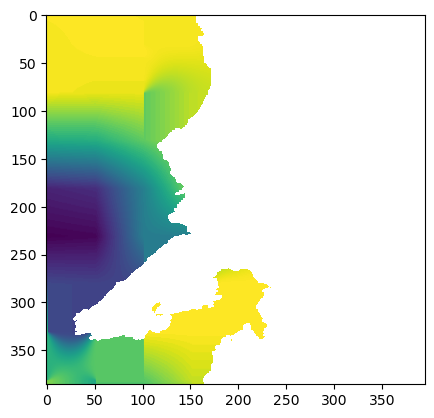

In [70]:
plt.imshow(sea_ice)

In [ ]:
#Here i fill the nan values with the interpolated ones
sea_ice_tif_interpolated = sea_ice_concentration_tif.copy()

for id in df.index:
    for year in common_years:
        nan_indices = np.isnan(sea_ice_concentration_tif.loc[id, year])
        sea_ice_tif_interpolated.loc[id, year][nan_indices] = interpolated_values.loc[id, year]

In [ ]:
for id in df.index:
    for year in common_years:
        sea_ice_tif_interpolated.loc[id, year] = np.where(sea_mask.loc[id, year] == True, sea_ice_tif_interpolated.loc[id, year], np.nan)

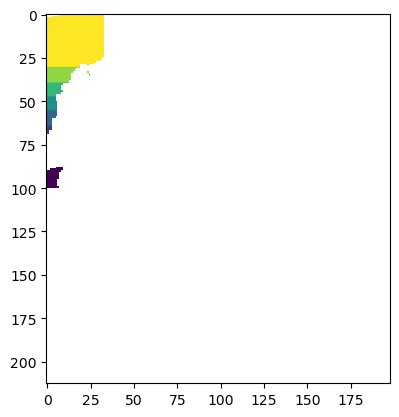

In [ ]:
plt.imshow(sea_ice_tif_interpolated.loc[57,2005])

In [ ]:
#save the interpolated sea ice concentration

#np.save(os.getcwd()+'/sea_ice_concentration_interpolated_tif.npy', sea_ice_tif_interpolated)


In [8]:
#load the interpolated sea ice concentration
sea_ice_tif_interpolated = np.load(os.getcwd()+'/sea_ice_concentration_interpolated_tif.npy', allow_pickle=True)

#Create dataset
sea_ice_tif_interpolated = pd.DataFrame(sea_ice_tif_interpolated, index = df.index, columns = common_years)

In [9]:
thickness_dir = '/Users/francesco/Desktop/Thesis/Thickness'

sea_mask = np.load(thickness_dir+'/sea_mask.npy', allow_pickle=True)
sea_mask = pd.DataFrame(sea_mask, index = df.index, columns = common_years)

ice_mask = np.load(thickness_dir+'/ice_mask.npy', allow_pickle=True) #CHANGE IN CLUSTER
ice_mask = pd.DataFrame(ice_mask, index = df.index, columns = common_years)
ice_mask_expanded = ice_mask.copy()

land_mask = np.load(thickness_dir+'/land_mask.npy', allow_pickle=True)
land_mask = pd.DataFrame(land_mask, index = df.index, columns = common_years)
land_mask_expanded = land_mask.copy()

grounded_ice_mask = np.load(thickness_dir+'/grounded_ice_mask.npy', allow_pickle=True)
grounded_ice_mask = pd.DataFrame(grounded_ice_mask, index = df.index, columns = common_years)
grounded_ice_mask_expanded = grounded_ice_mask.copy()

In [10]:
not_sea_mask = pd.DataFrame(index = df.index, columns = common_years)

for id in df.index:
    for year in common_years:
        not_sea_mask.loc[id,year] = (land_mask.loc[id,year] | grounded_ice_mask.loc[id,year] | ice_mask.loc[id,year])

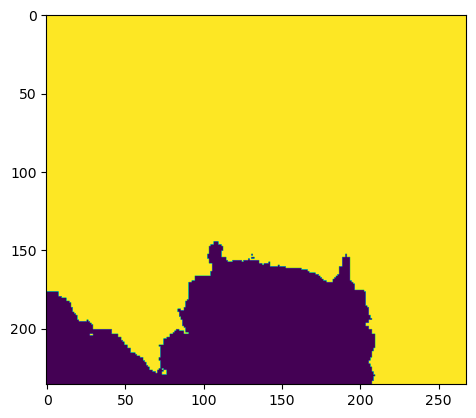

In [11]:
plt.imshow(not_sea_mask.loc[55,2010])

In [12]:
for id in df.index:
    for year in common_years:
        sea_ice_tif_interpolated.loc[id, year] = np.where(not_sea_mask.loc[id, year] == True, np.nan, sea_ice_tif_interpolated.loc[id, year])
        #sea_ice_tif_interpolated.loc[id, year] = np.where(grounded_ice_mask.loc[id, year] == True, np.nan, sea_ice_tif_interpolated.loc[id, year])
        #sea_ice_tif_interpolated.loc[id, year] = np.where(ice_mask.loc[id, year] == True, np.nan, sea_ice_tif_interpolated.loc[id, year])

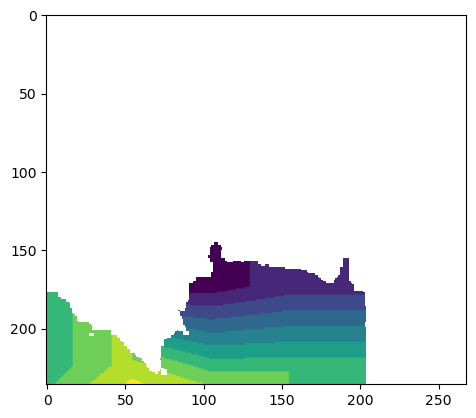

In [14]:
plt.imshow(sea_ice_tif_interpolated.loc[55, 2010])

In [61]:
for id in df.index:
    for year in common_years:

        sea_ice_tif_interpolated.loc[id, year] = np.where(not_sea_mask.loc[id, year] == True, 0, sea_ice_tif_interpolated.loc[id, year])

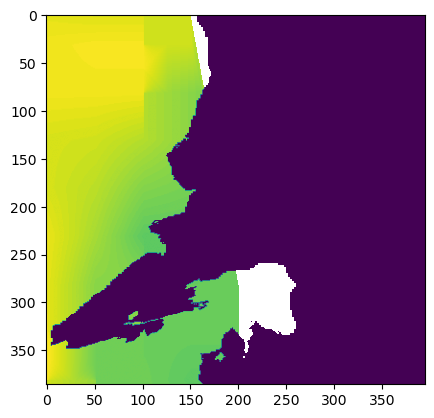

In [65]:
plt.imshow(sea_ice_tif_interpolated.loc[56,2010])
#plt.imshow(land_mask.loc[55,2010])